# Calculation of the correlation networks for the different conditions

Using Pearson and Spearman correlation, this notebook calculates pairwise ion correlations for the individual conditions of a dataset. The correlation distributions of a condition after different imputation/denoising methods are then compared.

In [1]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns
import re
import ast
from tqdm import tqdm
import sklearn

# Matplotlib command for Jupyter notebooks only
%matplotlib inline
plt.style.use('tableau-colorblind10')

In [2]:
# importing custom functions for imputation and evaluation
import sys

sys.path.append("/home/mklein/sc_imputation_denoising")
import sc_imputation_denoising as scid
from sc_imputation_denoising.imputation.constants import const

from sc_imputation_denoising.evaluation.evaluation_workflow import (
    evaluation_workflow,
)
# from sc_imputation_denoising.imputation.simulation import (
#     get_dropout_rate,
# )

IE version 1.3


/home/mklein/sc_imputation_denoising/sc_imputation_denoising/evaluation/evaluation_workflow.py:250: DeprecationWarning: invalid escape sequence '\d'
  .apply(lambda x: re.match("[\d\.]*", x).group(0))


In [1]:
max_fdr = 1
n_cells = 0.05
n_ions = 0.05
dataset = "Mx_Seahorse"
repl = 4
cond = 6
sim_method = "mnar"

In [ ]:
conf = f"cond{cond}_{sim_method}_c{n_cells}_i{n_ions}_fdr{max_fdr}_repl{repl}"
save_to = f"/g/alexandr/Marius/imputation_evaluation/{dataset}_{conf}"
if not os.path.exists(save_to):
    print("sample does not exist")
    # os.makedirs(save_to)
print(save_to)

In [ ]:
wflow = evaluation_workflow.get_from_pickle(
    f"/scratch/klein/temp/evaluation_pickle_{dataset}_{conf}_{repl}.pkl"
)
adata = wflow.dataset_dict[wflow.baseline_key].copy()
del wflow

In [50]:
adata

AnnData object with n_obs × n_vars = 7926 × 348
    obs: 'center_x', 'center_y', 'cell_area', 'cell_sampling_area', 'cell_sampling_ratio', 'cell_nearest_am_distance', 'cell_nearest_cell_distance', 'centroid-0', 'centroid-1', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'local_centroid-0', 'local_centroid-1', 'area', 'filled_area', 'solidity', 'perimeter', 'eccentricity', 'euler_number', 'moments_hu-0', 'moments_hu-1', 'moments_hu-2', 'moments_hu-3', 'moments_hu-4', 'moments_hu-5', 'moments_hu-6', 'moments_central-0-0', 'moments_central-0-1', 'moments_central-0-2', 'moments_central-0-3', 'moments_central-1-0', 'moments_central-1-1', 'moments_central-1-2', 'moments_central-1-3', 'moments_central-2-0', 'moments_central-2-1', 'moments_central-2-2', 'moments_central-2-3', 'moments_central-3-0', 'moments_central-3-1', 'moments_central-3-2', 'moments_central-3-3', 'inertia_tensor_eigvals-0', 'inertia_tensor_eigvals-1', 'major_axis_length', 'minor_axis_length', 'weighted_moments_central-0-0-DAPI', 

In [8]:
ions = adata.var_names
ion_df_list = []
for layer in [
    "ctrl",
    "knn_5",
    "MAGIC_t3",
    "ALRA",
    "dca_nb",
    "fancy_itersvd",
    "fancy_multi",
]:
    # for layer in adata.layers.keys():
    df = pd.DataFrame(
        adata[:, ions].layers[layer],
        columns=pd.MultiIndex.from_tuples([(layer, ion) for ion in ions]),
        index=adata.obs_names,
    )
    ion_df_list.append(df)

ion_df = pd.concat(ion_df_list, axis=1)

ion_df = pd.merge(
    ion_df, adata.obs[["condition", "sample"]], left_index=True, right_index=True
).set_index(["condition", "sample"], append=True)
ion_df.columns = pd.MultiIndex.from_tuples(ion_df.columns)
ion_df

/tmp/ipykernel_315/2230265032.py:22: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  ion_df = pd.merge(


ctrl                                   \
                          C2H5O5P-H C2H5O6P+Cl C2H7NO3S-H C2H8NO4P-H   
cell_id  condition sample                                              
160_B3   2DG       B3      2.628700   0.000000   6.013752   2.366710   
161_B3   2DG       B3      3.264712   0.000000   6.319481   2.772139   
162_B3   2DG       B3      3.225399   0.000000   6.062023   2.500917   
165_B3   2DG       B3      0.000000   0.000000   5.087159   1.589571   
166_B3   2DG       B3      2.924246   1.575778   6.355884   2.804527   
...                             ...        ...        ...        ...   
10324_E1 NStim     E1      2.323347   2.378417   4.624187   1.995213   
10329_E1 NStim     E1      2.487122   0.000000   5.635490   2.472082   
10334_E1 NStim     E1      2.301814   1.972756   5.138412   2.722960   
10336_E1 NStim     E1      1.901403   0.000000   4.106810   1.812372   
10340_E1 NStim     E1      1.878982   0.000000   5.109529   2.808146   

                                                                     \
                          C3H4O3+Cl C3H4O4+Cl C3H5O6P+Cl C3H5O7P+Cl   
cell_id  condition sample                                             
160_B3   2DG       B3      4.549981  2.628700   1.672979   2.165643   
161_B3   2DG       B3      4.554846  3.264712   2.408612   2.949085   
162_B3   2DG       B3      4.668251  3.225399   2.913580   2.605669   
165_B3   2DG       B3      4.751894  0.000000   2.341505   0.000000   
166_B3   2DG       B3      4.542167  2.924246   1.970069   2.101999   
...                             ...       ...        ...        ...   
10324_E1 NStim     E1      4.672669  2.323347   2.216612   2.354213   
10329_E1 NStim     E1      4.985275  2.487122   2.036270   1.859205   
10334_E1 NStim     E1      4.814778  2.301814   2.599607   0.000000   
10336_E1 NStim     E1      4.645023  1.901403   1.757875   0.000000   
10340_E1 NStim     E1      4.890103  1.878982   0.000000   0.000000   

                                                  ... fancy_multi             \
                          C3H7NO3+Cl C3H7NO5S+Cl  ...  C18H34O2-H C18H36O2-H   
cell_id  condition sample                         ...                          
160_B3   2DG       B3       2.366710    0.000000  ...    2.237229   3.152182   
161_B3   2DG       B3       2.772139    1.835784  ...    2.228570   2.046911   
162_B3   2DG       B3       2.500917    2.263711  ...    2.058397   2.576882   
165_B3   2DG       B3       1.589571    0.000000  ...    2.617398   3.746025   
166_B3   2DG       B3       2.804527    2.327842  ...    2.790462   3.249220   
...                              ...         ...  ...         ...        ...   
10324_E1 NStim     E1       1.995213    0.000000  ...    1.618439   2.965995   
10329_E1 NStim     E1       2.472082    1.923348  ...    1.630582   3.365504   
10334_E1 NStim     E1       2.722960    0.000000  ...    2.087127   3.243722   
10336_E1 NStim     E1       1.812372    0.000000  ...    2.303700   3.217790   
10340_E1 NStim     E1       2.808146    0.000000  ...    1.867285   3.267982   

                                                                       \
                          C19H37O6P-H C20H14N4-H C20H24N-H C20H32O2-H   
cell_id  condition sample                                               
160_B3   2DG       B3        3.255759   5.780750  4.625433   1.825880   
161_B3   2DG       B3        3.693720   5.563780  4.985447   1.948888   
162_B3   2DG       B3        3.231041   5.386508  4.622272   2.025652   
165_B3   2DG       B3        3.970881   5.716626  5.112604   1.568648   
166_B3   2DG       B3        3.471712   5.205285  4.547366   2.126546   
...                               ...        ...       ...        ...   
10324_E1 NStim     E1        2.882484   5.634567  4.762431   1.579875   
10329_E1 NStim     E1        3.254462   5.959392  5.322042   2.344364   
10334_E1 NStim     E1        2.988308   5.997491  5.325767   2.373791   
10336_E1 NStim     E1        3

In [9]:
long_ion_df = ion_df.reset_index().melt(
    id_vars=["cell_id", "condition", "sample"], var_name=["layer", "ion"]
)
long_ion_df

,cell_id,condition,sample,layer,ion,value
0,160_B3,2DG,B3,ctrl,C2H5O5P-H,2.628700
1,161_B3,2DG,B3,ctrl,C2H5O5P-H,3.264712
2,162_B3,2DG,B3,ctrl,C2H5O5P-H,3.225399
3,165_B3,2DG,B3,ctrl,C2H5O5P-H,0.000000
4,166_B3,2DG,B3,ctrl,C2H5O5P-H,2.924246
...,...,...,...,...,...,...
19307731,10324_E1,NStim,E1,fancy_multi,H4O7P2-H,5.704907
19307732,10329_E1,NStim,E1,fancy_multi,H4O7P2-H,4.159812
19307733,10334_E1,NStim,E1,fancy_multi,H4O7P2-H,4.301279
19307734,10336_E1,NStim,E1,fancy_multi,H4O7P2-H,3.695495


In [53]:
nonzero_mean_rel_df = pd.DataFrame(long_ion_df.groupby(['ion', 'layer'])['value'].agg(lambda x: (len(x) - sum(x > 0)) / len(x))).reset_index()
nonzero_mean_rel_df = nonzero_mean_rel_df[nonzero_mean_rel_df['layer'] == 'ctrl']
del nonzero_mean_rel_df['layer']
nonzero_mean_rel_df.columns = ['ion', 'nonzero']


In [54]:
mean_rel_df = pd.merge(
    nonzero_mean_rel_df, 
    long_ion_df.groupby(['ion', 'layer'])['value'].agg(lambda x: np.mean(x[x>0])).reset_index()
)

In [55]:
mean_rel_df

,ion,nonzero,layer,value
0,C10H10N2O-H,0.001388,ALRA,4.678914
1,C10H10N2O-H,0.001388,MAGIC_t3,4.693199
2,C10H10N2O-H,0.001388,ctrl,4.680567
3,C10H10N2O-H,0.001388,dca_nb,4.691986
4,C10H10N2O-H,0.001388,fancy_itersvd,4.678680
...,...,...,...,...
2431,H4O7P2-H,0.000631,ctrl,4.564022
2432,H4O7P2-H,0.000631,dca_nb,4.587219
2433,H4O7P2-H,0.000631,fancy_itersvd,4.562636
2434,H4O7P2-H,0.000631,fancy_multi,4.565570


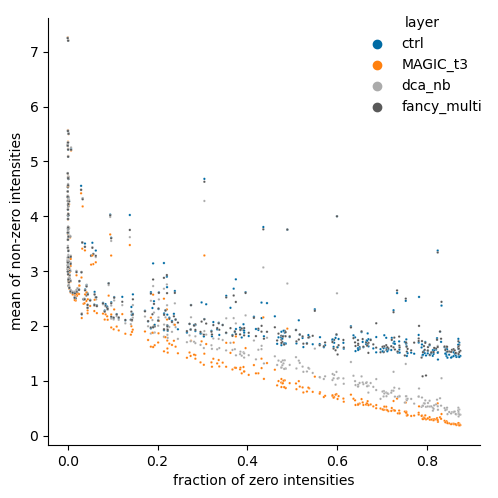

In [56]:
layers_direct_comp = ['ctrl', 'MAGIC_t3', 'dca_nb', 'fancy_multi']

fig = sns.relplot(
    data=mean_rel_df[mean_rel_df['layer'].isin(layers_direct_comp)],
    x='nonzero', y='value', hue='layer', hue_order=layers_direct_comp, s=3,
    facet_kws=dict(legend_out=False)
)
fig.set_ylabels('mean of non-zero intensities')
fig.set_xlabels('fraction of zero intensities')
sns.move_legend(fig, loc='upper right', frameon=False, bbox_to_anchor=(1, 1))

In [10]:
nonzero_df = long_ion_df.loc[long_ion_df["layer"] == "ctrl"].copy()

nonzero_df["value"] = nonzero_df["value"].replace(0, np.nan)
nonzero_df["layer"] = "ctrl_nonzero"

In [11]:
nonzero_df

,cell_id,condition,sample,layer,ion,value
0,160_B3,2DG,B3,ctrl_nonzero,C2H5O5P-H,2.628700
1,161_B3,2DG,B3,ctrl_nonzero,C2H5O5P-H,3.264712
2,162_B3,2DG,B3,ctrl_nonzero,C2H5O5P-H,3.225399
3,165_B3,2DG,B3,ctrl_nonzero,C2H5O5P-H,NaN
4,166_B3,2DG,B3,ctrl_nonzero,C2H5O5P-H,2.924246
...,...,...,...,...,...,...
2758243,10324_E1,NStim,E1,ctrl_nonzero,H4O7P2-H,5.704907
2758244,10329_E1,NStim,E1,ctrl_nonzero,H4O7P2-H,4.159812
2758245,10334_E1,NStim,E1,ctrl_nonzero,H4O7P2-H,4.301279
2758246,10336_E1,NStim,E1,ctrl_nonzero,H4O7P2-H,3.695495


In [12]:
ion_comp_df = pd.concat([long_ion_df, nonzero_df])
ion_comp_df = ion_comp_df.pivot(
    index=["cell_id", "layer", "sample", "condition"], columns="ion", values="value"
).reset_index()
ion_comp_df

ion,cell_id,layer,sample,condition,C10H10N2O-H,C10H10N2O2-H,C10H10N2O4S-H,C10H11N3O2S-H,C10H12N2O-H,C10H12N2O8+Cl,...,C9H7NO2+Cl,C9H7NO2-H,C9H8O3-H,C9H9N+Cl,C9H9N-H,C9H9NO-H,C9H9NO2-H,C9H9NO3-H,CH4NO5P+Cl,H4O7P2-H
0,10000_E1,ALRA,E1,NStim,4.795621,3.362235,3.442304,0.000000,1.557127,0.000000,...,0.000000,3.446006,2.370101,0.000000,3.619084,2.760159,2.707909,1.539202,0.000000,4.534116
1,10000_E1,MAGIC_t3,E1,NStim,4.751682,3.202606,3.200539,0.859922,0.604842,0.535328,...,0.243178,3.430807,1.340728,0.519532,3.696934,2.733932,2.496985,0.383968,0.394866,4.613115
2,10000_E1,ctrl,E1,NStim,4.583380,2.993997,3.648416,0.000000,0.000000,0.000000,...,0.000000,3.503863,2.264619,0.000000,3.670011,3.426861,2.562785,0.000000,0.000000,4.975636
3,10000_E1,ctrl_nonzero,E1,NStim,4.583380,2.993997,3.648416,NaN,NaN,NaN,...,NaN,3.503863,2.264619,NaN,3.670011,3.426861,2.562785,NaN,NaN,4.975636
4,10000_E1,dca_nb,E1,NStim,4.770731,3.269862,3.325539,2.523092,1.094668,1.111474,...,0.307408,3.271100,1.796776,1.419256,3.637090,2.763750,2.609300,0.735141,0.658913,4.938140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63403,999_B3,ctrl_nonzero,B3,2DG,4.479803,3.165502,2.727110,NaN,NaN,3.434275,...,NaN,2.944338,1.787916,NaN,3.215578,2.410917,2.364680,NaN,1.961230,5.101246
63404,999_B3,dca_nb,B3,2DG,4.440979,2.894130,2.772791,0.608570,0.917409,3.361536,...,0.646144,3.249904,1.442890,1.200823,3.412141,2.221454,2.103174,0.679845,1.532632,5.023423
63405,999_B3,fancy_itersvd,B3,2DG,4.479803,3.165502,2.727110,2.578745,1.176178,3.434275,...,2.502329,2.944338,1.787916,1.631595,3.215578,2.410917,2.364680,2.159355,1.961230,5.101246
63406,999_B3,fancy_multi,B3,2DG,4.479803,3.165502,2.727110,3.087129,1.802211,3.434275,...,1.828567,2.944338,1.787916,1.572639,3.215578,2.410917,2.364680,1.825621,1.961230,5.101246


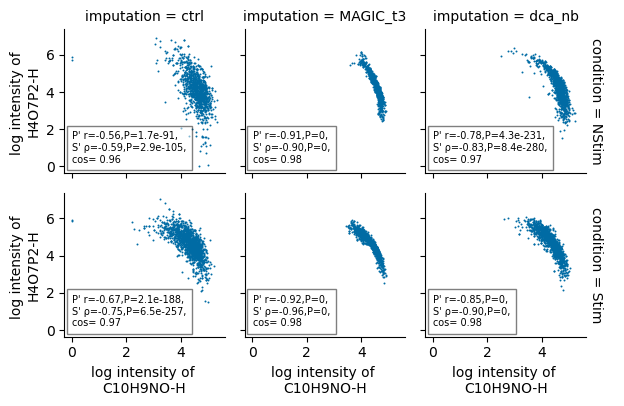

In [77]:
analysis_ions = ['C10H9NO-H', 'H4O7P2-H']#, 'C5H5N5-H', 'H4O7P2-H', 'C4H8O5-H', 'C5H10O2-H', 'C2H5O5P-H', 'C6H10O5-H']
for i in range(0, len(analysis_ions), 2):
    i_grid = sns.FacetGrid(
        ion_comp_df, 
        col='layer', col_order=['ctrl', 'MAGIC_t3', 'dca_nb'],
        row='condition', row_order=['NStim', 'Stim',],
        margin_titles=True, height=2)
    i_plot = i_grid.map_dataframe(sns.scatterplot, x=analysis_ions[i], y=analysis_ions[i+1], s=2, linewidth=0)
    i_plot.add_legend()
    scid.evaluation.utils.print_stat_info_on_grid(i_grid, dropna=True, methods=['pearson', 'spearman', 'cosine'], posx=0.05, posy=0.29)
    i_grid.set_titles(row_template='condition = {row_name}', col_template='imputation = {col_name}')
    i_grid.set_axis_labels('log intensity of \n' + analysis_ions[i], 'log intensity of \n' + analysis_ions[i+1])
    i_grid.fig.savefig(f'/home/mklein/Dropouts/figures/ion_scatter_{analysis_ions[i]}_{analysis_ions[i+1]}.pdf')

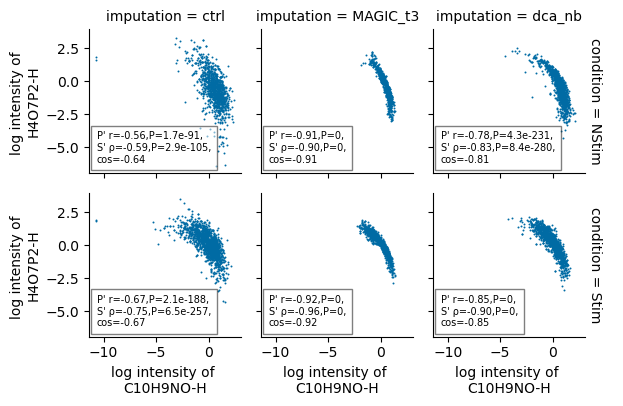

In [19]:
mod_ion_comp_df = ion_comp_df.copy()
mod_ion_comp_df[analysis_ions] = ion_comp_df[analysis_ions].apply(
    lambda x: (x - x.mean()) / x.std()
)
analysis_ions = ["C10H9NO-H", "H4O7P2-H"]
for i in range(0, len(analysis_ions), 2):
    i_grid = sns.FacetGrid(
        mod_ion_comp_df,
        col="layer",
        col_order=["ctrl", "MAGIC_t3", "dca_nb"],
        row="condition",
        row_order=[
            "NStim",
            "Stim",
        ],
        margin_titles=True,
        height=2,
    )
    i_plot = i_grid.map_dataframe(
        sns.scatterplot, x=analysis_ions[i], y=analysis_ions[i + 1], s=2, linewidth=0
    )
    i_plot.add_legend()
    imp_eval.print_stat_info_on_grid(
        i_grid,
        dropna=True,
        methods=["pearson", "spearman", "cosine"],
        posx=0.05,
        posy=0.29,
    )
    i_grid.set_titles(
        row_template="condition = {row_name}", col_template="imputation = {col_name}"
    )
    i_grid.set_axis_labels(
        "log intensity of \n" + analysis_ions[i],
        "log intensity of \n" + analysis_ions[i + 1],
    )
    i_grid.fig.savefig(
        f"/home/mklein/Dropouts/figures/ion_scatter_{analysis_ions[i]}_{analysis_ions[i+1]}.pdf"
    )

In [145]:
corr_method = "pearson"
# corr_method = "spearman"

In [146]:
import itertools
from sklearn.metrics.pairwise import cosine_similarity

corr_df_list = []
for layer in tqdm(ion_comp_df.layer.unique()):
    to_corr_df = ion_comp_df[ion_comp_df["layer"] == layer].set_index(
        ["cell_id", "layer", "sample", "condition"]
    )

    corr_matrix = to_corr_df.corr(method=corr_method)
    corr_matrix = (corr_matrix + 1) / 2
    corr_df = pd.DataFrame(
        corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        ).stack()
    )

    corr_df.columns = [(layer, "all")]
    corr_df_list.append(corr_df)

    for condition in ion_comp_df.condition.unique():
        to_corr_df = ion_comp_df[
            (ion_comp_df["layer"] == layer) & (ion_comp_df["condition"] == condition)
        ].set_index(["cell_id", "layer", "sample", "condition"])
        if corr_method == "cosine":
            corr_combinations = pd.DataFrame(
                itertools.combinations(to_corr_df.columns, r=2)
            )

            def cosine(row):
                corr_df_this = to_corr_df[[row[0], row[1]]].dropna()
                a = corr_df_this[row[0]]
                b = corr_df_this[row[1]]
                # Calculate cosine similarity using NumPy
                row["cosine"] = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
                return row

            corr_df = corr_combinations.parallel_apply(cosine, axis=1)
            corr_df = corr_df.set_index([0, 1])
            corr_df.index.names = ["ion", "ion"]
        else:
            corr_matrix = to_corr_df.corr(method=corr_method)
            corr_matrix = (corr_matrix + 1) / 2
            corr_df = pd.DataFrame(
                corr_matrix.where(
                    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
                ).stack()
            )

        corr_df.columns = [(layer, condition)]
        corr_df_list.append(corr_df)

100%|██████████| 8/8 [00:39<00:00,  4.98s/it]


In [147]:
corr_df = pd.concat(corr_df_list, axis=1)
corr_df.index.names = ["ion1", "ion2"]
corr_df.columns = pd.MultiIndex.from_tuples(corr_df.columns)
corr_df.to_csv(os.path.join(save_to, f"nonzero_correlation_{corr_method}.csv"))
corr_df = corr_df.replace(np.nan, 0)
long_corr_df = corr_df.melt(
    var_name=["layer", "condition"], ignore_index=False
).reset_index()
corr_df

ALRA                                          \
                                all     NStim       2DG     Oligo      Stim   
ion1        ion2                                                              
C10H10N2O-H C10H10N2O2-H   0.949737  0.960074  0.949914  0.966905  0.954389   
            C10H10N2O4S-H  0.831163  0.865478  0.880904  0.877437  0.841627   
            C10H11N3O2S-H  0.528623  0.534788  0.487505  0.491558  0.511121   
            C10H12N2O-H    0.874492  0.920699  0.882892  0.928692  0.883990   
            C10H12N2O8+Cl  0.274505  0.306031  0.263848  0.284069  0.240178   
...                             ...       ...       ...       ...       ...   
C9H9NO2-H   CH4NO5P+Cl     0.323199  0.330207  0.366038  0.315490  0.323004   
            H4O7P2-H       0.159459  0.163254  0.189098  0.152116  0.123525   
C9H9NO3-H   CH4NO5P+Cl     0.340752  0.345004  0.357653  0.313853  0.317268   
            H4O7P2-H       0.173423  0.176045  0.176250  0.137521  0.147268   
CH4NO5P+Cl  H4O7P2-H       0.808288  0.747801  0.808812  0.805333  0.807514   

                           MAGIC_t3                                          \
                                all     NStim       2DG     Oligo      Stim   
ion1        ion2                                                              
C10H10N2O-H C10H10N2O2-H   0.925054  0.967895  0.904103  0.960694  0.949835   
            C10H10N2O4S-H  0.872561  0.926384  0.907354  0.905327  0.866068   
            C10H11N3O2S-H  0.537495  0.564231  0.447118  0.444420  0.494270   
            C10H12N2O-H    0.841708  0.821339  0.876373  0.882300  0.874888   
            C10H12N2O8+Cl  0.187785  0.142083  0.168657  0.146010  0.130941   
...                             ...       ...       ...       ...       ...   
C9H9NO2-H   CH4NO5P+Cl     0.168902  0.160563  0.233375  0.203771  0.114470   
            H4O7P2-H       0.140687  0.147015  0.174416  0.148093  0.070602   
C9H9NO3-H   CH4NO5P+Cl     0.197995  0.205098  0.209760  0.179544  0.155652   
            H4O7P2-H       0.165196  0.187834  0.167850  0.152611  0.124708   
CH4NO5P+Cl  H4O7P2-H       0.941137  0.932245  0.933312  0.942676  0.947586   

                           ... fancy_multi                                \
                           ...         all     NStim       2DG     Oligo   
ion1        ion2           ...                                             
C10H10N2O-H C10H10N2O2-H   ...    0.817875  0.810368  0.808113  0.838308   
            C10H10N2O4S-H  ...    0.676212  0.656390  0.687927  0.680073   
            C10H11N3O2S-H  ...    0.463890  0.453276  0.465708  0.430922   
            C10H12N2O-H    ...    0.495270  0.514539  0.510291  0.452605   
            C10H12N2O8+Cl  ...    0.259523  0.292119  0.265614  0.229104   
...                        ...         ...       ...       ...       ...   
C9H9NO2-H   CH4NO5P+Cl     ...    0.443176  0.427283  0.444409  0.423100   
            H4O7P2-H       ...    0.350099  0.400757  0.347190  0.387235   
C9H9NO3-H   CH4NO5P+Cl     ...    0.663786  0.704503  0.645773  0.677978   
            H4O7P2-H       ...    0.542637  0.642788  0.534990  0.586269   
CH4NO5P+Cl  H4O7P2-H       ...    0.746698  0.775388  0.735422  0.803888   

                                        knn_5                                \
                               Stim       all     NStim       2DG     Oligo   
ion1        ion2                                                              
C10H10N2O-H C10H10N2O2-H   0.834297  0.817493  0.810031  0.807677  0.837884   
            C10H10N2O4S-H  0.655870  0.676328  0.655235  0.688996  0.678224   
            C10H11N3O2S-H  0.385770  0.481773  0.424674  0.504984  0.425998   
            C10H12N2O-H    0.404356  0.485116  0.502287  0.500737  0.437125   
            C10H12N2O8+Cl  0.281612  0.264520  0.353235  0.264890  0.228551   
...                             ...       ...       ...       ...       ...   
C9H9NO2-H   CH4NO5P+Cl     0.427649  0.45

In [34]:
datasets = dict(
    Mx_Seahorse=dict(c = 0.1, i = 0.2, repl = 1, cond=4),
    Lx_Pancreatic_Cancer=dict(c = 0.2, i = 0.05, repl = 1, cond=4),
    Lx_Glioblastoma=dict(c = 0.05, i = 0.05, repl = 4, cond=6),
    Lx_HepaRG=dict(c = 0.2, i = 0.2, repl = 5, cond=4)
)
dataset = 'Mx_Seahorse'
dataset = 'Lx_Glioblastoma'
params = datasets[dataset]
sim_method = 'mnar'
sparse = True
if sparse:
    sparse_text = '_sparse'
else:
    sparse_text = ''
    
max_fdr = 1
conf = f"cond{params['cond']}_{sim_method}_c{params['c']}_i{params['i']}_fdr{max_fdr}_repl{params['repl']}"
save_to = f"/g/alexandr/Marius/imputation_evaluation/{dataset}_{conf}"
if not os.path.exists(save_to):
    print('sample does not exist')
    # os.makedirs(save_to)
print(save_to)
if sparse:
    adata = sc.read(f'{save_to}/adata_sparse.h5ad')
else:
    adata = sc.read(f'{save_to}/adata_baseline.h5ad')

/g/alexandr/Marius/imputation_evaluation/Lx_Glioblastoma_cond6_mnar_c0.05_i0.05_fdr1_repl4


In [15]:
if sparse:
    adata = sc.read(f'{save_to}/adata_sparse.h5ad')
else:
    adata = sc.read(f'{save_to}/adata_baseline.h5ad')

adata.obs.index.name = 'cell_id'
ions = adata.var_names
ion_df_list = []
for layer in ["ctrl", "knn_5", "MAGIC_t3", "ALRA", "dca_nb", "fancy_itersvd", "fancy_multi"]:
    # for layer in adata.layers.keys():
    df = pd.DataFrame(
        adata[:, ions].layers[layer],
        columns=pd.MultiIndex.from_tuples([(layer, ion) for ion in ions]),
        index=adata.obs_names,
    )
    ion_df_list.append(df)

ion_df = pd.concat(ion_df_list, axis=1)

ion_df = pd.merge(
    ion_df, adata.obs[["condition", "sample"]], left_index=True, right_index=True
).set_index(["condition", "sample"], append=True)
ion_df.columns = pd.MultiIndex.from_tuples(ion_df.columns)

long_ion_df = ion_df.reset_index().melt(
    id_vars=["cell_id", "condition", "sample"], var_name=["layer", "ion"]
)
nonzero_df = long_ion_df.loc[long_ion_df["layer"] == "ctrl"].copy()

nonzero_df["value"] = nonzero_df["value"].replace(0, np.nan)
nonzero_df["layer"] = "ctrl_nonzero"
ion_comp_df = pd.concat([long_ion_df, nonzero_df])
ion_comp_df = ion_comp_df.pivot(
    index=["cell_id", "layer", "sample", "condition"], columns="ion", values="value"
).reset_index()

to_corr_df = ion_comp_df.set_index(['cell_id', 'layer', 'sample', 'condition'])
long_values_df = to_corr_df.melt(var_name=['ion'], ignore_index=False).dropna()

n_values_df = long_values_df.groupby(['layer', 'condition', 'ion'])['value'].count()
n_values_all_df = long_values_df.groupby(['layer', 'ion'])['value'].count()
n_values = n_values_df.groupby(['condition', 'layer']).mean()
n_values_all = n_values_all_df.groupby(['layer']).mean()

n_values.to_csv(os.path.join(save_to, f"n_values{sparse_text}.csv"))

/tmp/ipykernel_173/1279008682.py:20: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  ion_df = pd.merge(


In [36]:
n_values = pd.read_csv(os.path.join(save_to, f"n_values{sparse_text}.csv"), index_col=[0, 1])['value']
n_values

condition    layer        
Naive_WT     ALRA             3023.000000
             MAGIC_t3         3023.000000
             ctrl             3023.000000
             ctrl_nonzero      461.841916
             dca_nb           3023.000000
             fancy_itersvd    3023.000000
             fancy_multi      3023.000000
             knn_5            3023.000000
TMD_CD95_KO  ALRA             1422.000000
             MAGIC_t3         1422.000000
             ctrl             1422.000000
             ctrl_nonzero      194.922156
             dca_nb           1422.000000
             fancy_itersvd    1422.000000
             fancy_multi      1422.000000
             knn_5            1422.000000
TMD_CD95_WT  ALRA             1928.000000
             MAGIC_t3         1928.000000
             ctrl             1928.000000
             ctrl_nonzero      264.731737
             dca_nb           1928.000000
             fancy_itersvd    1928.000000
             fancy_multi      1928.000000
       

In [37]:
const.NARROW_BBOX.update(fc=(1, 1, 1, 0.6))
os.path.join(save_to, f"nonzero_correlation_{corr_method}{sparse_text}.csv")

'/g/alexandr/Marius/imputation_evaluation/Lx_Glioblastoma_cond6_mnar_c0.05_i0.05_fdr1_repl4/nonzero_correlation_pearson_sparse.csv'

In [38]:
corr_df = pd.read_csv(os.path.join(save_to, f"nonzero_correlation_{corr_method}{sparse_text}.csv"), index_col=[0, 1], header=[0,1])
#corr_df = corr_df.replace(np.nan, 0)
#corr_df = (corr_df + 1) / 2
long_corr_df = corr_df.melt(var_name=['layer', 'condition'], ignore_index=False).reset_index()
corr_df

ALRA                                  \
                              TMD_sM    TMD_dM TMD_CD95_WT    TMD_tM   
ion1         ion2                                                      
C10H20NO8P+K C21H38O3+H     0.273575  0.286375    0.328194  0.337960   
             C21H39O6P+H    0.462423  0.481549    0.493670  0.482824   
             C21H39O6P+Na   0.475817  0.548757    0.487904  0.567813   
             C21H40O3+H     0.348065  0.304087    0.421197  0.398828   
             C21H41O6P+Na   0.317719  0.301032    0.298974  0.341497   
...                              ...       ...         ...       ...   
C45H78O2+Na  C61H98O5+K          NaN  0.711281    0.645970  0.734471   
             C62H109NO18+H       NaN  0.763795    0.670042  0.750095   
             C63H113O12P+K       NaN  0.770010    0.715663  0.720107   
             C65H115O12P+K       NaN  0.806700    0.674008  0.718317   
             C65H117O12P+K       NaN  0.818711    0.679888  0.765740   

                                                  MAGIC_t3            \
                           TMD_CD95_KO  Naive_WT    TMD_sM    TMD_dM   
ion1         ion2                                                      
C10H20NO8P+K C21H38O3+H       0.365617  0.375116  0.387467  0.369043   
             C21H39O6P+H      0.536327  0.537201  0.504475  0.504563   
             C21H39O6P+Na     0.521935  0.531155  0.516324  0.548886   
             C21H40O3+H       0.405208  0.427004  0.448948  0.360138   
             C21H41O6P+Na     0.308134  0.347744  0.528355  0.481460   
...                                ...       ...       ...       ...   
C45H78O2+Na  C61H98O5+K       0.681218  0.760637  0.664087  0.774295   
             C62H109NO18+H    0.714617  0.736774  0.752123  0.852326   
             C63H113O12P+K    0.702610  0.738510  0.797143  0.856425   
             C65H115O12P+K    0.694951  0.731363  0.728518  0.825665   
             C65H117O12P+K    0.744552  0.761836  0.689699  0.805695   

                                                  ... fancy_multi            \
                           TMD_CD95_WT    TMD_tM  ... TMD_CD95_WT    TMD_tM   
ion1         ion2                                 ...                         
C10H20NO8P+K C21H38O3+H       0.388500  0.390142  ...    0.498791  0.507960   
             C21H39O6P+H      0.540411  0.510138  ...    0.540235  0.520051   
             C21H39O6P+Na     0.541830  0.530308  ...    0.551811  0.595090   
             C21H40O3+H       0.434353  0.415162  ...    0.525444  0.519682   
             C21H41O6P+Na     0.506417  0.467498  ...    0.488406  0.518615   
...                                ...       ...  ...         ...       ...   
C45H78O2+Na  C61H98O5+K       0.683400  0.574894  ...    0.528117  0.526902   
             C62H109NO18+H    0.780847  0.607607  ...    0.524013  0.483788   
             C63H113O12P+K    0.782892  0.615931  ...    0.474874  0.517740   
             C65H115O12P+K    0.731122  0.590212  ...    0.517358  0.499811   
             C65H117O12P+K    0.720740  0.522844  ...    0.568603  0.544100   

                                                     knn_5            \
                           TMD_CD95_KO  Naive_WT    TMD_sM    TMD_dM   
ion1         ion2                                                      
C10H20NO8P+K C21H38O3+H       0.490851  0.443717  0.668050  0.593363   
             C21H39O6P+H      0.534498  0.558358  0.674336  0.618361   
             C21H39O6P+Na     0.499338  0.494288  0.697553  0.690490   
             C21H40O3+H       0.567911  0.474000  0.680188  0.618426   
             C21H41O6P+Na     0.487234  0.487711  0.674239  0.661646   
...                                ...       ...       ...       ...   
C45H78O2+Na  C61H98O5+K       0.504360  0.539498  0.643341  0.571673   
             C62H109NO18+H    0.489158  0.539803  0.665704  0.596234   
             C63H113O12P+K    0.554697  0.489169  0.655036  0.622292   
             C65H115O12P+K    0.520429  0.5

In [12]:
hue_dict = {'baseline': (0.6257796880873904, 0.7692334467518679, 0.8490464152850072),
    'ctrl': (0.31288984404369524, 0.5944206449445615, 0.746091835093484),
    'ctrl_nonzero': (0.0, 0.4196078431372549, 0.6431372549019608),
    'fancy_itersvd': (0.976249987924192, 0.7208024833334978, 0.4948461379450622),
    'fancy_multi': (1.0, 0.5019607843137255, 0.054901960784313725),
    'knn_3': (0.6450787385143271, 0.6450943494613806, 0.6450330062267311),
    'knn_5': (0.34901960784313724, 0.34901960784313724, 0.34901960784313724),
    'ALRA': (0.37254901960784315, 0.6196078431372549, 0.8196078431372549),
    'MAGIC_t1': (0.8679748929727327, 0.6302059588557253, 0.46777925759729744),
    'MAGIC_t3': (0.7843137254901961, 0.3215686274509804, 0.0),
    'dca_nb': (0.7395654837909705, 0.7395810602898067, 0.7395199624957123),
    'dca_zinb': (0.5372549019607843, 0.5372549019607843, 0.5372549019607843)
}

x_order = ['ctrl', 'ctrl_nonzero', 'MAGIC_t3', 'dca_nb', 'ALRA', 'fancy_itersvd', 'knn_5', 'fancy_multi']
palette = {key: value for key, value in hue_dict.items() if key in x_order}
palette

{'ctrl': (0.31288984404369524, 0.5944206449445615, 0.746091835093484),
 'ctrl_nonzero': (0.0, 0.4196078431372549, 0.6431372549019608),
 'fancy_itersvd': (0.976249987924192, 0.7208024833334978, 0.4948461379450622),
 'fancy_multi': (1.0, 0.5019607843137255, 0.054901960784313725),
 'knn_5': (0.34901960784313724, 0.34901960784313724, 0.34901960784313724),
 'ALRA': (0.37254901960784315, 0.6196078431372549, 0.8196078431372549),
 'MAGIC_t3': (0.7843137254901961, 0.3215686274509804, 0.0),
 'dca_nb': (0.7395654837909705, 0.7395810602898067, 0.7395199624957123)}

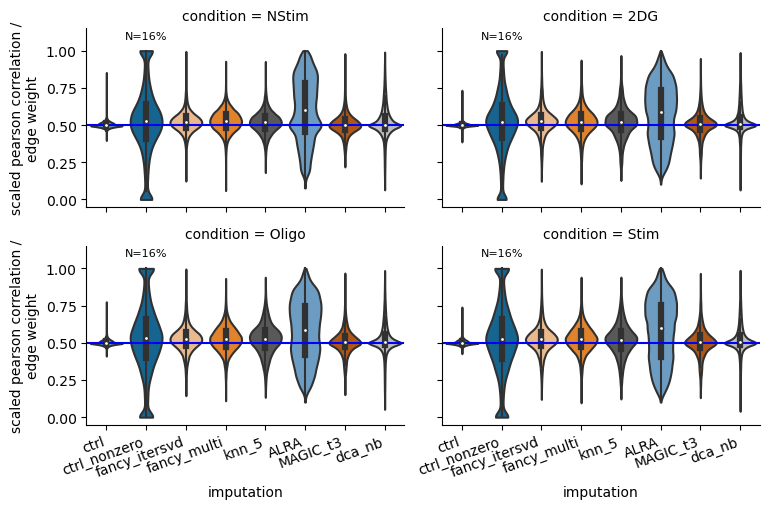

In [256]:

col_wrap = 2
cond_df = long_corr_df[long_corr_df['condition'] != "all"]
text = f"scaled {corr_method} correlation /\nedge weight"
fig = sns.catplot(
    data=cond_df,
    kind='violin', cut=0, scale='width',
    x='layer', order=palette.keys(),
    y='value',
    col='condition', col_wrap=col_wrap, height=2.6, aspect=1.5, palette=palette.values(),
)

# for i in range(0, len(fig.axes.flat), col_wrap):
#     fig.axes.flat[i].text(-1, 1.1, f'N =', ha='left', va='center', size=8)

for ax, condition in zip(fig.axes, cond_df.condition.unique()):
    ax.set_ylim(ax.get_ylim()[0], 1.15)
    if corr_method != "cosine":
        ax.axhline(y=0.5, color='blue')
    for i, layer in enumerate(x_order):
        if layer == 'ctrl_nonzero':
            try:
                ax.annotate(
                    f"N={n_values.loc[condition, 'ctrl_nonzero'] / n_values.loc[condition, 'ctrl']:.0%}", 
                    xy=(i, 1.1),
                    ha='center', va='center', size=8, bbox=const.NARROW_BBOX,
                    )
            except Exception as e:
                print(e)
                
            

fig.set_xticklabels(rotation=20, ha='right')
fig.set_ylabels(text)
fig.set_xlabels('imputation')
fig.tight_layout()
fig.savefig(os.path.join(save_to, f"corr_effect_{corr_method}{sparse_text}.png"))
fig.savefig(os.path.join(save_to, f"corr_effect_{corr_method}{sparse_text}.pdf"))



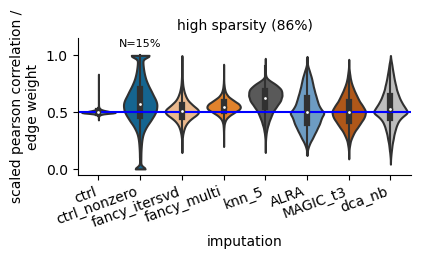

In [39]:
col_wrap = 2
cond = 'Naive_WT'
cond_df = long_corr_df[long_corr_df['condition'] == cond]
text = f"scaled {corr_method} correlation /\nedge weight"
fig = sns.catplot(
    data=cond_df,
    kind='violin', cut=0, scale='width',
    x='layer', order=palette.keys(),
    y='value',
    col='condition', col_wrap=col_wrap, height=2.6, aspect=1.5, palette=palette.values(),
)

# for i in range(0, len(fig.axes.flat), col_wrap):
#     fig.axes.flat[i].text(-1, 1.1, f'N =', ha='left', va='center', size=8)

for ax, condition in zip(fig.axes, cond_df.condition.unique()):
    ax.set_ylim(ax.get_ylim()[0], 1.15)
    if corr_method != "cosine":
        ax.axhline(y=0.5, color='blue')
    for i, layer in enumerate(x_order):
        if layer == 'ctrl_nonzero':
            try:
                ax.annotate(
                    f"N={n_values.loc[condition, 'ctrl_nonzero'] / n_values.loc[condition, 'ctrl']:.0%}", 
                    xy=(i, 1.1),
                    ha='center', va='center', size=8, bbox=const.NARROW_BBOX,
                    )
            except Exception as e:
                print(e)
                
            
if sparse:
    fig.set_titles(f'high sparsity ({adata.uns["dropout_rate"]:.0%})')
    # fig.set_yticklabels([0.0, 0.5, 1.0])

else:
    fig.set_titles('baseline sparsity')
fig.set_ylabels(text)
fig.set_xticklabels(rotation=20, ha='right')

fig.set_xlabels('imputation')
fig.tight_layout()
fig.savefig(os.path.join(save_to, f"corr_effect_{corr_method}{sparse_text}_{cond}.pdf"))



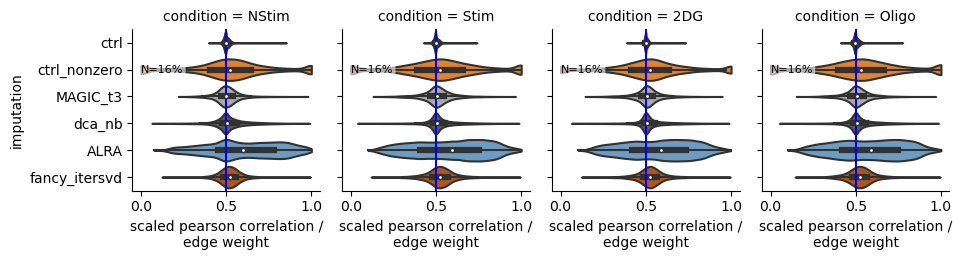

In [251]:
col_wrap = 4
fig = sns.catplot(
    data=cond_df,
    kind='violin', cut=0, scale='width',
    y='layer', order=x_order,
    x='value',
    col='condition', col_order=const.COND_ORDER[dataset],
    col_wrap=col_wrap, height=2.7, aspect=0.9,
)

# for i in range(0, len(fig.axes.flat)):
#     fig.axes.flat[i].text(0.15, ax.get_ylim()[1], f'N =', ha='right', va='center', size=8)
for ax, condition in zip(fig.axes, cond_df.condition.unique()):
    #ax.set_xlim(, ax.get_xlim()[1])
    if corr_method != "cosine":
        ax.axvline(x=0.5, color='blue')
    for i, layer in enumerate(x_order):
        if layer == 'ctrl_nonzero':
            ax.annotate(
                f"N={n_values.loc[condition, 'ctrl_nonzero'] / n_values.loc[condition, 'ctrl']:.0%}", 
                xy=(0, i),
                ha='left', va='center', size=8, bbox=const.NARROW_BBOX,
                )

#fig.set_xticklabels(rotation=20, ha='right')
fig.set_xlabels(text)
fig.set_ylabels('imputation')
fig.tight_layout()
fig.savefig(os.path.join(save_to, f"corr_effect_{corr_method}{sparse_text}_horiz.png"))
fig.savefig(os.path.join(save_to, f"corr_effect_{corr_method}{sparse_text}_horiz.pdf"))

